In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
import gym
env = gym.envs.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # YOUR CODE HERE
        return self.l2(self.relu(self.l1(x)))

In [4]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = QNetwork(num_hidden)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

In [5]:
import random

class NoneMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        # YOUR CODE HERE
        self.memory.append(transition)

    def sample(self, batch_size):
        # YOUR CODE HERE
        index = np.random.choice(len(self), batch_size, replace=False)
        return [self.memory[i] for i in index]

    def sample(self, batch_size):
        # YOUR CODE HERE
        return self.memory[-batch_size:]

    def __len__(self):
        return len(self.memory)


class UniformMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        # YOUR CODE HERE
        self.memory.append(transition)

    def sample(self, batch_size):
        # YOUR CODE HERE
        index = np.random.choice(len(self), batch_size, replace=False)
        return [self.memory[i] for i in index]

    def __len__(self):
        return len(self.memory)

In [6]:
class SumTree(object):
    """
    This SumTree code is modified version of Morvan Zhou: 
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    """
    data_pointer = 0
    
    """
    Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes (final nodes) that contains experiences
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        """ tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0  [Size: capacity] it's at this line that there is the priorities score (aka pi)
        """
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    """
    Here we add our priority score in the sumtree leaf and add the experience in data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        
        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index  0 0  0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update (tree_index, priority)
        
        # Add 1 to data_pointer
        self.data_pointer += 1
        
        if self.data_pointer >= self.capacity:  # If we're above the capacity, you go back to first index (we overwrite)
            self.data_pointer = 0
            
    
    """
    Update the leaf priority score and propagate the change through tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # then propagate the change through tree
        while tree_index != 0:    # this method is faster than the recursive loop in the reference code
            
            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    
    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True: # the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node
                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                    
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

    
class PrioritizedMemory(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at his leaf
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def push(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        self.tree.add(max_priority, experience)   # set the max p for new p

        
    """
    - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
    - Then a value is uniformly sampled from each range
    - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contains the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment
    
        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1
        
        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sample from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   
            b_idx[i]= index
            
            experience = [data]
            
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [7]:
capacity = 10
memory = NoneMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))

[(array([ 0.02295733,  0.02183008,  0.00092248,  0.02490857]), 0, 1.0, array([ 0.02339393, -0.17330509,  0.00142065,  0.3178824 ]), False)]


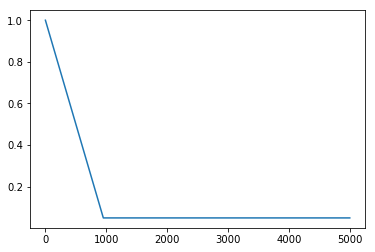

In [8]:
def get_epsilon(it):
    # YOUR CODE HERE
    if it == 0:
        return 1
    return np.maximum(1 - it/1000, 0.05)

# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])

In [9]:
def select_action(model, state, epsilon):
    # YOUR CODE HERE
    with torch.no_grad():
        actionProbs = model(torch.Tensor(state)).numpy()
    action = np.random.choice(len(actionProbs), 1) if np.random.rand() < epsilon else np.argmax(actionProbs)
    return int(action.squeeze())

s = env.reset()
a = select_action(model, s, 0.05)
assert not torch.is_tensor(a)
print (a)

1


In [10]:
def compute_q_val(model, state, action):
    # YOUR CODE HERE
    return torch.gather(model(state), 1, action.unsqueeze(1)).squeeze()
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE
    x = reward * done.to(torch.float)
    notdone = (done + 1) % 2
    maxV, maxA = torch.max(model(next_state), 1)
    y = (reward + discount_factor * maxV) * notdone.to(torch.float)
    return x + y

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [11]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(model.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(model, memory, optimizer, batch_size, discount_factor)

print (loss)

NameError: name 'ReplayMemory' is not defined

In [19]:
# YOUR CODE HERE
def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    optimizer = optim.Adam(model.parameters(), learn_rate)

    durations = torch.zeros(num_episodes)
    iteration = 0

    for episode in tqdm(range(num_episodes)):
        s = env.reset()
        done = False
        while not done:
            a = select_action(model, s, get_epsilon(iteration))
            s_next, r, done, _ = env.step(a)
            transition = (s, a, r, s_next, done)
            memory.push(transition)
            s = s_next
            train(model, memory, optimizer, batch_size, discount_factor)
            durations[episode] += 1
            iteration += 1

    return durations

In [20]:
def run(er_type='uniform'):
    # Let's run it!
    num_episodes = 100
    batch_size = 64
    discount_factor = 0.8
    learn_rate = 1e-3
    
    er_types = {
        'none': NoneMemory,
        'uniform': UniformMemory,
        'prioritized': PrioritizedMemory
    }

    memory = er_types[er_type](10000)
    num_hidden = 128
    seed = 42  # This is not randomly chosen

    # We will seed the algorithm (before initializing QNetwork!) for reproducability
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    model = QNetwork(num_hidden)

    episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)
    return episode_durations

100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


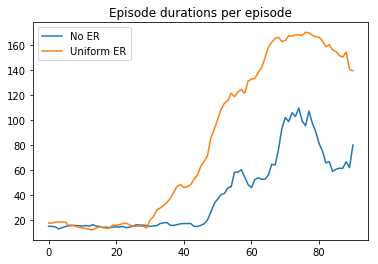

In [21]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

runs = {
    'none': 'No ER',
    'uniform': 'Uniform ER'
}

for er_type in runs:
    plt.plot(smooth(run(er_type), 10))
plt.title('Episode durations per episode')
plt.legend([runs[er_type] for er_type in runs])

# plt.plot(smooth(none_episode_durations, 10))
# plt.plot(smooth(random_episode_durations, 10))
# plt.title('Episode durations per episode')
# plt.legend(['No ER', 'Vanilla ER'])

In [15]:
def train_true_gradient(model, memory, optimizer, batch_size, discount_factor):
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    target = compute_target(model, reward, next_state, done, discount_factor)
    target = torch.autograd.Variable(target)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations_true_gradient = run_episodes(
    train_true_gradient, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

plt.plot(smooth(episode_durations, 10))
plt.plot(smooth(episode_durations_true_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Semi-gradient', 'True gradient'])

NameError: name 'seed' is not defined